In [589]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from fuzzywuzzy import fuzz #conda install -c conda-forge fuzzywuzzy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #conda install -c conda-forge wordcloud
import plotly.graph_objects as go #conda install -c plotly plotly=4.7.1
from textblob import TextBlob #conda install -c conda-forge textblob



sns.set_palette("muted")
tweets = pd.read_csv('data/train.csv')
tweets

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

In [528]:
tweets_text = tweets.loc[:,['text','target']]
tweets_text['target_boolean'] = tweets_text['target']
tweets_text['target'] = tweets_text['target'].transform(lambda x: 'Real' if x == 1 else 'Falso')
tweets_text

text target  target_boolean
0     Our Deeds are the Reason of this #earthquake M...   Real               1
1                Forest fire near La Ronge Sask. Canada   Real               1
2     All residents asked to 'shelter in place' are ...   Real               1
3     13,000 people receive #wildfires evacuation or...   Real               1
4     Just got sent this photo from Ruby #Alaska as ...   Real               1
...                                                 ...    ...             ...
7608  Two giant cranes holding a bridge collapse int...   Real               1
7609  @aria_ahrary @TheTawniest The out of control w...   Real               1
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   Real               1
7611  Police investigating after an e-bike collided ...   Real               1
7612  The Latest: More Homes Razed by Northern Calif...   Real               1

[7613 rows x 3 columns]

# Cuál es la distribución entre tweets Reales y Falsos? 

Text(0.5, 0, 'Tweet')

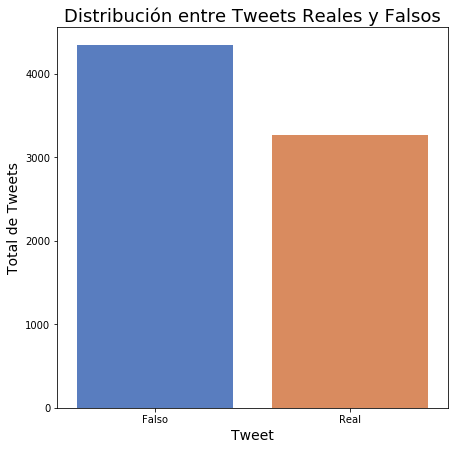

In [529]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Distribución entre Tweets Reales y Falsos",fontsize= 18)
ax.set_ylabel("Total de Tweets",fontsize= 14)
ax.set_xlabel("Tweet",fontsize= 14)

# Relación cantidad de palabras del tweet y veracidad

Se indica para cada tweet cuantas palabras posee el texto

In [530]:
tweets_text['total_words'] = tweets_text.text.transform(lambda x: len(x.split(" ")))


Text(0, 0.5, 'Frecuencia')

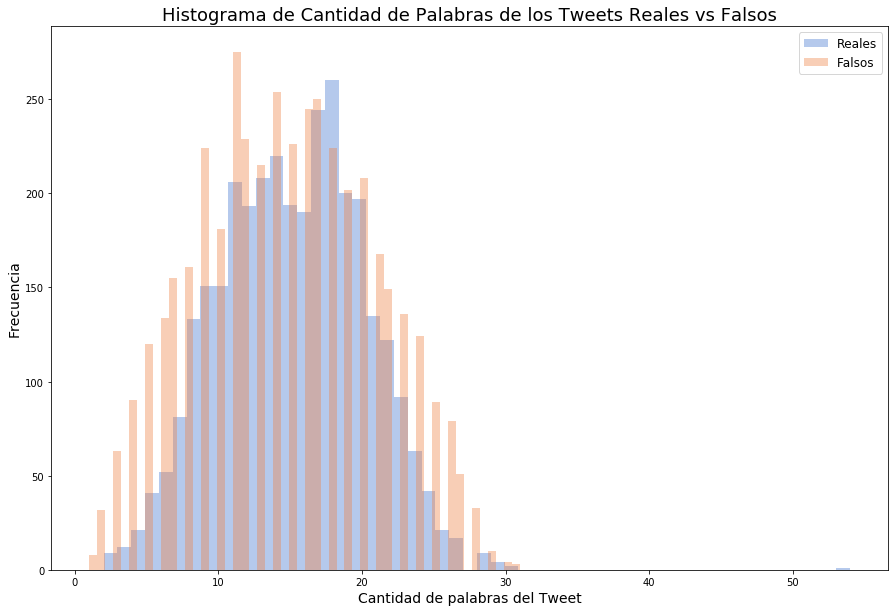

In [531]:
rcParams['figure.figsize'] = 15,10
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_words'],  kde=False, label='Reales', bins = 54)
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_words'],  kde=False, label='Falsos',bins = 54)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Palabras de los Tweets Reales vs Falsos",fontsize= 18)
plt.xlabel("Cantidad de palabras del Tweet",fontsize= 14)
plt.ylabel('Frecuencia',fontsize= 14)

# Relación entre la cantidad de caracteres y  veracidad del tweet

In [532]:
tweets_text['len_text'] = tweets_text.text.transform(lambda x: len(x))


Text(0, 0.5, 'Frecuencia')

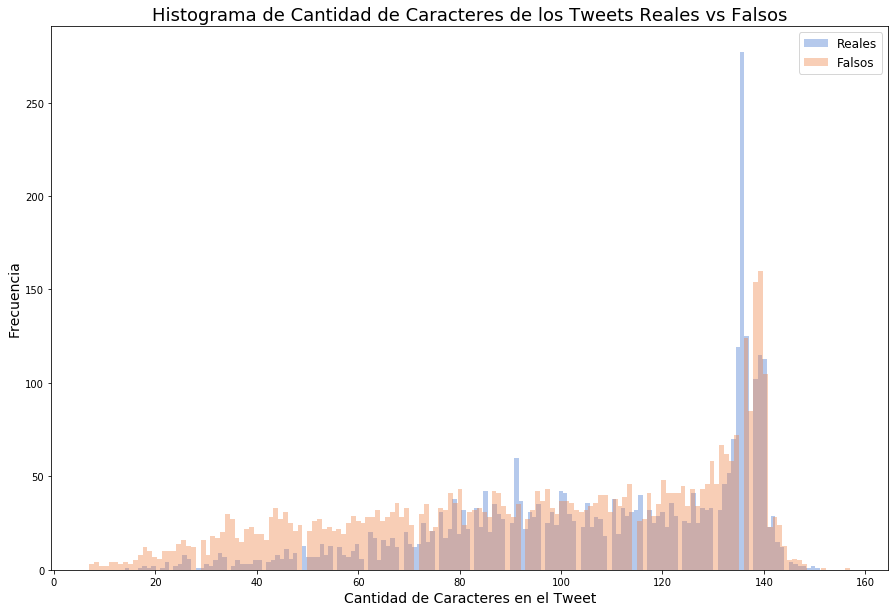

In [533]:
total_bins = tweets_text.len_text.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','len_text'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','len_text'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres de los Tweets Reales vs Falsos",fontsize= 18)
plt.xlabel("Cantidad de Caracteres en el Tweet",fontsize= 14)
plt.ylabel('Frecuencia',fontsize= 14)

# ¿Existe diferencias entre las distribuciones de los tweets según su cantidad de palabras y longitud del texto?

In [534]:
tweets_text['len_text_normal'] = (tweets_text.len_text-tweets_text.len_text.mean()) /np.std(tweets_text.len_text)
tweets_text['total_words_normal'] = (tweets_text.total_words-tweets_text.total_words.mean()) /np.std(tweets_text.total_words)


Text(0.5, 1.0, 'Distribución normalizada (normalización estandar) de\n la cantidad de palabras vs la cantidad de caracteres del texto')

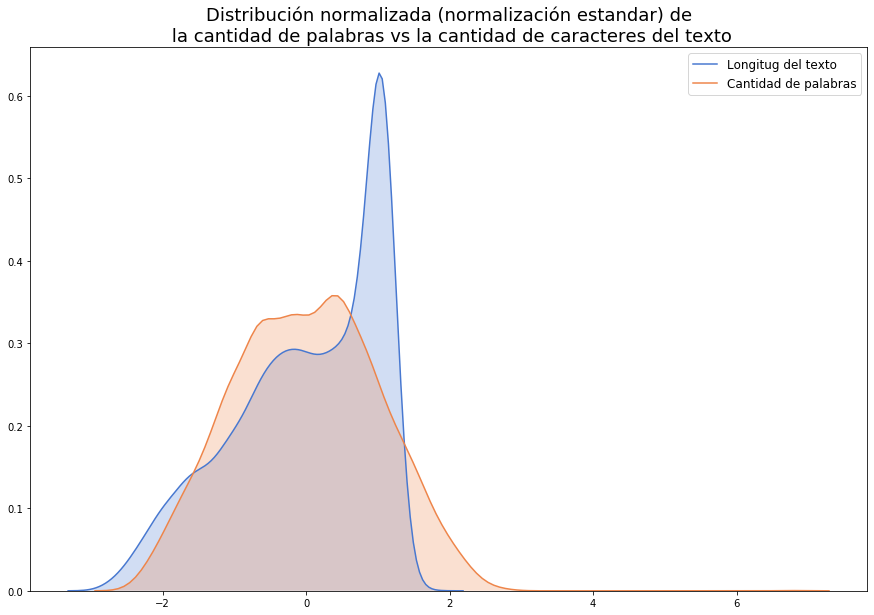

In [535]:
sns.kdeplot(tweets_text.len_text_normal, label='Longitug del texto',shade=True)
sns.kdeplot(tweets_text.total_words_normal, label='Cantidad de palabras',shade=True)
plt.legend(prop={'size': 12})
plt.title("Distribución normalizada (normalización estandar) de\n la cantidad de palabras vs la cantidad de caracteres del texto",fontsize=18)





# Cuál es la correlación entre la cantidad de palabras del tweet y su longitud separados por target?

Text(26.93980577256945, 0.5, 'Total de Palabras')

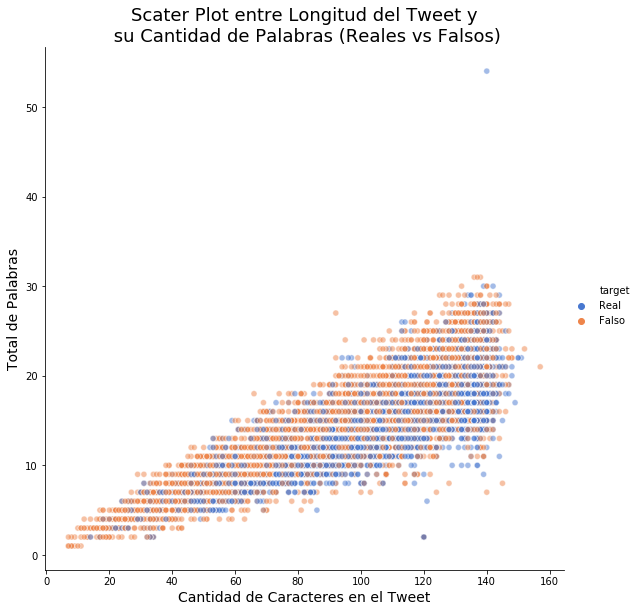

In [536]:
scater = sns.relplot(y="total_words", x="len_text", hue="target", alpha=.5,height=8, data=tweets_text)
plt.title("Correlación entre la Longitud del Tweet y\n su Cantidad de Palabras (Reales vs Falsos)",fontsize= 18)
plt.xlabel("Cantidad de Caracteres en el Tweet",fontsize= 14)
plt.ylabel('Total de Palabras',fontsize= 14)

# Relación entre la cantidad de caracteres de un tipo específico (mayusculas,numéricos y especiales) y la veracidad del tweet

In [537]:
#Recibe un string y devuelve la cantidad de caracteres en mayusculas que posee
def get_upper_total(s):
    total = 0
    for x in s:
        y = ord(x)
        if y > 90:
            continue
        if y > 64:
            total = total + 1
    return total

#Recibe un string y devuelve la cantidad de caracteres numéricos que posee
def get_total_numbers_chars(s):
    total = 0
    for x in s:
        y = ord(x)
        if y in range(48,58):
            total = total + 1
    return total
#Recibe un string y devuelve la cantidad de caracteres especiales que posee (excluye una lista de caracteres comunes)
def get_special_chars_total(s):
    total = 0
    common_esp_chr = [" ",".","?",",","!"]
    for x in s:
        y = ord(x)
        if y in range(97,123) or y in range(65,91) or y in range(48,58) or x in common_esp_chr:
            continue
        total = total + 1
    return total

Se obtiene para cada tweet la cantidad de caracteres en mayusculas que posee el texto

In [538]:
tweets_text['total_upper_chars'] = tweets_text.text.transform(lambda x: get_upper_total(x))

Se obtiene para cada tweet la cantidad de caracteres numéricos que posee el texto

In [539]:
tweets_text['total_numbers_chars'] = tweets_text.text.transform(lambda x: get_total_numbers_chars(x))

Se obtiene para cada tweet la cantidad de caracteres especiales que posee el texto (sin incluir los mas comunes)

In [540]:
tweets_text['total_special_chars'] = tweets_text.text.transform(lambda x: get_special_chars_total(x))

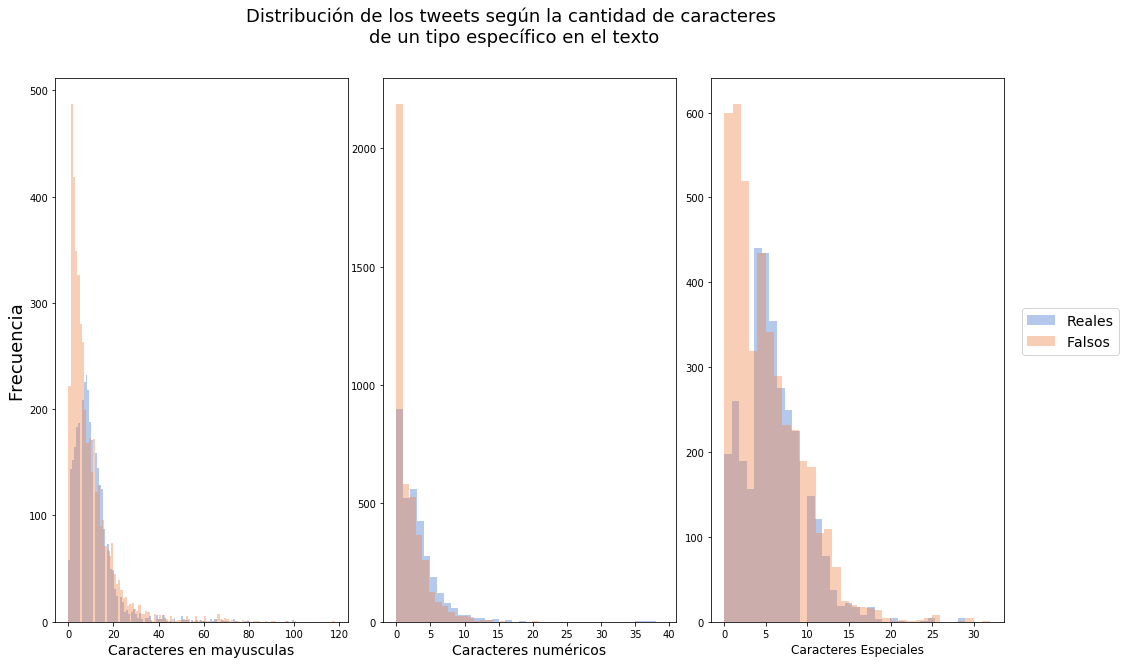

In [541]:

f, ax = plt.subplots(1, 3, figsize=(17,10),gridspec_kw={'wspace': 0.12})

total_bins = tweets_text.total_upper_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_upper_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[0])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_upper_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[0])
ax[0].set_xlabel("Caracteres en mayusculas", fontsize=14)
ax[0].set_ylabel('Frecuencia', fontsize=18)



total_bins = tweets_text.total_numbers_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_numbers_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[1])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_numbers_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[1])
ax[1].set_xlabel("Caracteres numéricos", fontsize=14)



total_bins = tweets_text.total_special_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_special_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[2])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_special_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[2])
ax[2].set_xlabel("Caracteres Especiales", fontsize=12)

f.suptitle('Distribución de los tweets según la cantidad de caracteres \nde un tipo específico en el texto', fontsize=18)
f.legend(["Reales","Falsos"],prop={'size': 14},loc=5)


# ¿Incluyen los tweets elementos especiales como preguntas o enlaces ? como se distribuyen con relación al target

Indicamos para cada tweet si posee o no una pregunta (se asume que la posee si contiene el caracter "?")

In [542]:
tweets_text['contain_question'] = tweets_text.text.transform(lambda x: "?" in x)

Indicamos para cada tweet si posee o no un enlace (se asume que la posee si contiene "http")

In [543]:
tweets_text['contain_link'] = tweets_text.text.transform(lambda x: "http" in x)

Text(0.5, 0.98, 'Bar Plot del target de los tweets que contienen enlaces y preguntas')

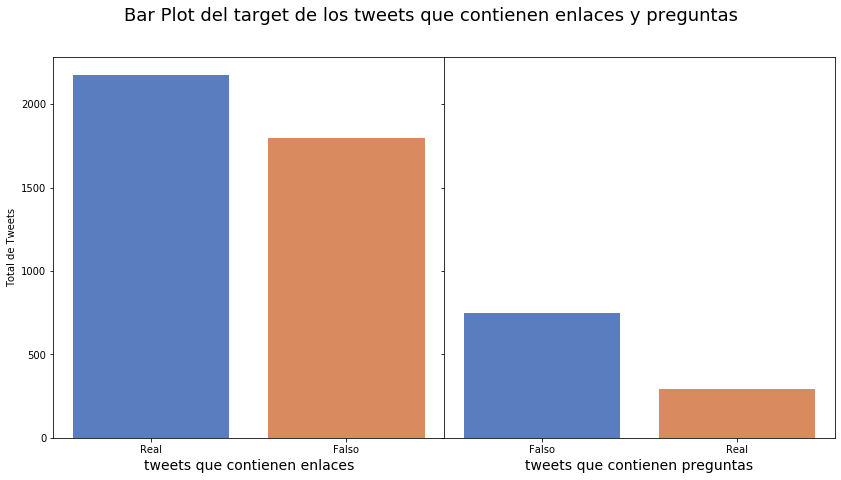

In [544]:
f, ax = plt.subplots(1, 2, figsize=(14,7),gridspec_kw={'wspace': 0})

sns.barplot(data = tweets_text.loc[tweets_text.contain_link == True].target.value_counts().reset_index(),x='index',y='target',ax=ax[0])
ax[0].set_ylabel("Total de Tweets")
ax[0].set_xlabel("tweets que contienen enlaces",fontsize=14)

sns.barplot(data = tweets_text.loc[tweets_text.contain_question == True].target.value_counts().reset_index(),x='index',y='target',ax=ax[1])
ax[1].set_xlabel("tweets que contienen preguntas",fontsize=14)

ax[0].label_outer()
ax[1].label_outer()
ax[1].set_ylim(ax[0].get_ylim())

f.suptitle('Bar Plot del target de los tweets que contienen enlaces y preguntas', fontsize=18)


# Analisis del "sentimiento" del texto

La biblioteca de textblob posee una función que analiza el "sentimiento" de un texto, generando dos métricas llamadas polaridad y subjetividad. La primera es un float entre -1 y 1, para la cual mientras mas cerca del 1 este entonces es un sentimiento positivo (es más negativo mientras más se acerca al -1 y es más neutro cuanto más se acerque al 0). La segunda es un float entre 0 y 1, el sentimiento será más subjetivo cuanto mayor sea el valor.   

In [590]:
def subjectivityText(x):
  t=TextBlob(x)
  return t.sentiment.subjectivity
def polarityText(x):
  t=TextBlob(x)
  return t.sentiment.polarity

Se generan las columnas con su respectiva polaridad y subjetividad de cada texto

In [591]:
tweets_text["subjectivity_text"]=tweets_text.text.transform(subjectivityText)
tweets_text["polarity_text"]=tweets_text.text.transform(polarityText)


#  ¿Se puede establecer un conjunto de palabras que dado un tweet que contenga al menos una, indique si es real o falso?


Para esto se hará un analsis de cada palabra en base a su frecuencia y longitud, el cual consistirá en buscar las palabras y su grado de veracidad (sobre aquellos tweets que contienen la palabra: porcentaje que son reales) 

Se crea un DataFrame con todas las palabras y sus frecuencias 

In [545]:
words = []
for x in tweets_text.text.tolist():
    for y in x.split(" "):
        words.append(y.lower())
df_words = pd.Series(words).value_counts().to_frame().reset_index()
df_words.columns = ['word','frecuency']

In [546]:
# Recibe las listas l1=[a1,a2,...,an] y l2=[b1,b2,...,bm] y las extiendea ambas a n x m elementos con la forma:
#  l1=[a1,...,a1,a2,...,a2,...,an,...,an] (m veces para cada elemento)
#  l2=[b1,b2,...,bm,b1,b2,...,bm] (n veces para cada m elementos)
#  Además devuelve una tercera lista con el producto cartesiano de las dos listas anteriores
def separate_cartesian_product_list(lenght_list, frecuency_list):
    first_list = lenght_list.copy()
    second_list = frecuency_list.copy()
    for x in range(len(second_list)-1):
        lenght_list.extend(first_list)
    lenght_list.sort()  
    for x in range(len(first_list)-1):
        frecuency_list.extend(second_list)
    
    third_list = []
    for x in first_list:
        for y in second_list:
            third_list.append((x,y))
    return third_list

In [547]:
#Se crean dos listas, la primera contiene todas las longitudes mínimas y la segunda contiene las frecuencias mínimas
#que se imponen para pertenecer al conjuto de palabras más frecuentes. 
#Se crea un dataframe donde cada registro determina un conjunto de palabras, ya que este contiene las variables antes 
#mencionadas y además una dupla con los mismos valores
word_lenght = list(range(1,10))
word_frecuency = list(range(10,140,5))

len_vs_fre = separate_cartesian_product_list(word_lenght,word_frecuency)
tweets_frec_len = pd.DataFrame({'lenght_min':word_lenght,'frecuency_min':word_frecuency, 'len_and_fre':len_vs_fre}) 


In [548]:
#Recibe un string y una colección de palabras, devuelve True en caso que al menos una de las palabras del string
#este contenida en la colección, Devuelve Falso para el caso contrario. 
def contain_long_words(s,long_words):
    for x in s.lower().split(" "):
        if x in long_words:
            return True
    return False

In [549]:
#Recibe una dupla de elementos: (longitud min,frecuencia min). devuelve el porcentaje de tweets reales de aquellos
#que continen al menos una palabra del conjunto de palabras mas frecuentes determinados por longitud min y frecuencia min
def get_true_percentage(x):
    long_words = df_words.loc[df_words['word'].transform(lambda y: len(y) >=  x[0])].loc[df_words.frecuency >= x[1],'word'].tolist()
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,long_words))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == 'Real','target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == 'Falso','target'].count()

    return total_true*100/(total_true +total_False)

El siguiente dataframe indica los porcentajes de tweets reales de aquellos que por lo menos una de sus palabras se encuentran en las palabras más frecuentes de logintud min y frecuencia min especificados

In [580]:
tweets_frec_len['true_percentage'] = tweets_frec_len['len_and_fre'].transform(lambda x: get_true_percentage(x)) 
data_for_heatmap =tweets_frec_len.drop(columns=['len_and_fre']).set_index(['frecuency_min','lenght_min']).unstack()
data_for_heatmap.columns = list(range(1,10))



Text(114.0, 0.5, 'Frecuencia mínima de las palabras mas frecuentes')

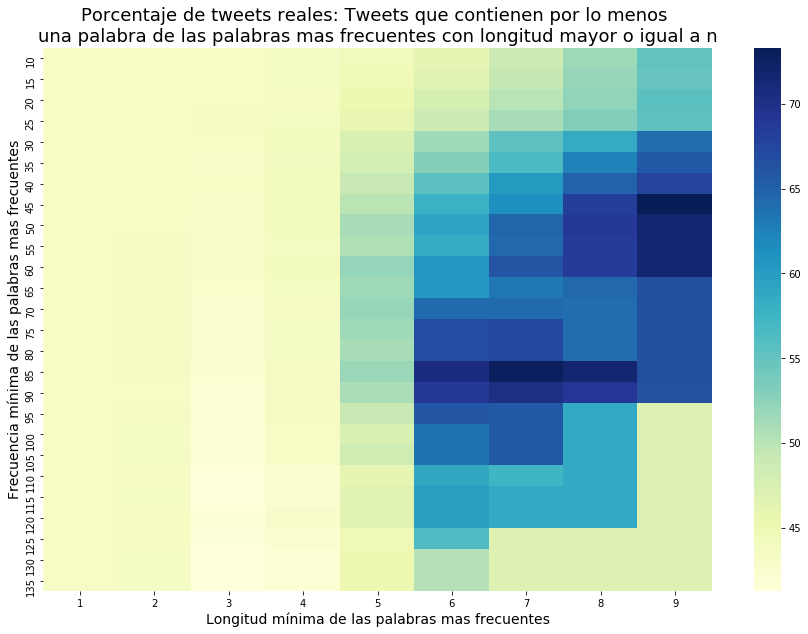

In [581]:
rcParams['figure.figsize'] = 15,10
heatmap = sns.heatmap(data_for_heatmap,cmap="YlGnBu")
heatmap.set_title("Porcentaje de tweets reales: Tweets que contienen por lo menos \nuna palabra de las palabras mas frecuentes con longitud mayor o igual a n",fontsize= 18)
heatmap.set_xlabel("Longitud mínima de las palabras mas frecuentes",fontsize= 14)
heatmap.set_ylabel("Frecuencia mínima de las palabras mas frecuentes",fontsize= 14)


In [552]:
def get_true_pertentage_word(x):
    x_list = []
    x_list.append(x)
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,x_list))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == 'Real','target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == 'Falso','target'].count()
    if (total_true +total_False) == False:
        print(x)
        print(tweets_contain_long_words)
    return total_true*100/(total_true +total_False),total_true

In [553]:
words_set = pd.DataFrame(df_words.loc[df_words['word'].transform(lambda y: len(y) >=  5)].loc[df_words.frecuency >= 30,'word'].tolist())
words_set['percentage_true'] = words_set[0].transform(lambda x: get_true_pertentage_word(x))
words_set['total_tweets_true'] = words_set['percentage_true'].transform(lambda x: x[1]).astype('int')
words_set['percentage_true'] = words_set['percentage_true'].transform(lambda x: x[0]).astype('int')


Se toman las palabras tienen más de un 75% de veracidad y que haya más de 30 de estos (este sería el conjunto de palabras buscados)

In [554]:
best_words = words_set.loc[words_set.percentage_true > 75].loc[words_set.total_tweets_true >30][0].tolist()


Se indica a cada tweet si contiene o no al menos una palabra de esta "bolsa de palabras"

In [555]:
tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,best_words))

Text(0.5, 0, 'Tweets')

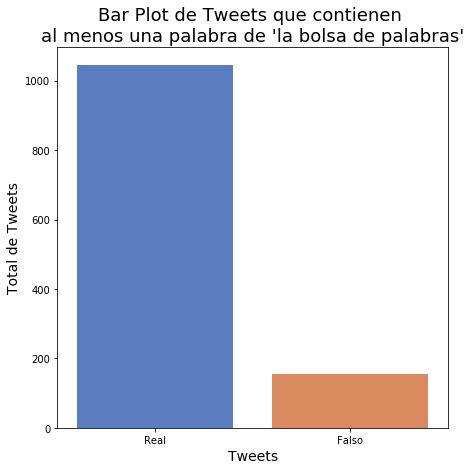

In [556]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.loc[tweets_text['contain_long_word'] == True].target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Bar Plot de Tweets que contienen \nal menos una palabra de 'la bolsa de palabras'",fontsize= 18)
ax.set_ylabel("Total de Tweets",fontsize= 14)
ax.set_xlabel("Tweets",fontsize= 14)


# ¿Cuales son los Keywords con mayor frecuencia ?

In [557]:
tweets_text_key = tweets.loc[:,['text','keyword','target']].dropna()

Agrupación de keyword por similitud

In [558]:
#Recibe una lista de keywords y regresa un diccionario cuyas claves son los elementos de la lista pasada y los valores
#son las keywords agrupadas que las representa
def get_keyword_dic(key_list):
    key_dic = {}
    unique_list = []
    for x in key_list:
        z = x
        if "%20" in x:
            z = " ".join(x.split("%20"))
        similarity = 0
        value = ""
        for y in unique_list:
            ratio = fuzz.ratio(z,y)
            if ratio > similarity:
                similarity = ratio
                value = y
        if similarity > 75:
            key_dic[x] = value
        else:
            key_dic[x] = z
            unique_list.append(z)
    return key_dic
key_grouped = get_keyword_dic(tweets_text_key.keyword.tolist())

Agrupoamiento manual

In [559]:
key_grouped['blazing'] = 'ablaze'
key_grouped['bleeding'] = 'blood'
key_grouped['buildings%20on%20fire'] = 'buildings burning'
key_grouped['burning%20buildings'] = 'buildings burning'
key_grouped['burning'] = 'burned'
key_grouped['dead'] = 'death'
key_grouped['demolition'] = 'demolish'
key_grouped['destruction'] = 'destroy'
key_grouped['explosion'] = 'explode'
key_grouped['flood'] = 'flooding'
key_grouped['floods'] = 'flooding'
key_grouped['inundated'] = 'inundation'
key_grouped['panic'] = 'panicking'
key_grouped['rainstorm'] = 'rainstorm'
key_grouped['riot'] = 'rioting'
key_grouped['screaming'] = 'screamed'
key_grouped['snowstorm'] = 'snowstorm'
key_grouped['survivors'] = 'survive'
key_grouped['traumatised'] = 'trauma'
key_grouped['violent%20storm'] = 'storm'
key_grouped['windstorm'] = 'storm'
key_grouped['traumatised'] = 'trauma'

tweets_text_key['keyword_grouped'] = tweets_text_key.keyword.transform(lambda x: key_grouped[x])


 Visualización wordcloud de las keywords categóricas

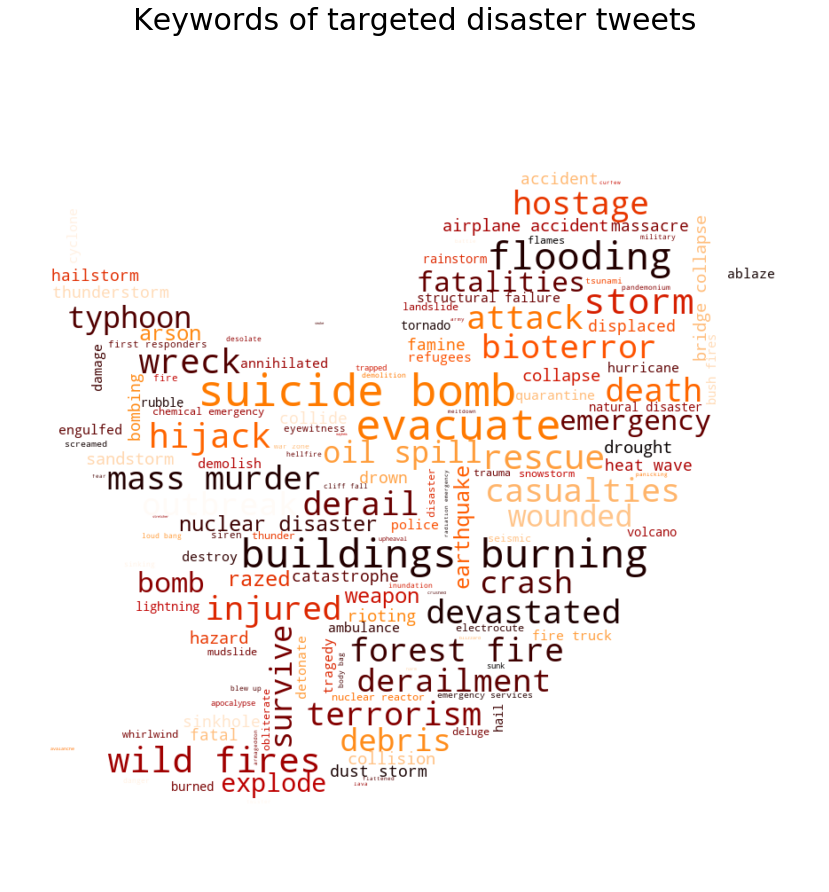

In [560]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

keywords_count = tweets_text_key.loc[tweets['target'] == 1].keyword_grouped.value_counts()
keywords_count.index = keywords_count.index.map(str)

mask = np.array(Image.open("./img/twitter_black.png"))
mask_transformed = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    mask_transformed[i] = list(map(transform_format, mask[i]))

wordcloud = WordCloud(max_font_size=50, max_words=200, random_state=42, 
                      background_color='white', colormap='gist_heat',
                      mask=mask_transformed)
wordcloud.generate_from_frequencies(keywords_count)

plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Keywords of targeted disaster tweets", fontsize=30, pad=40)
plt.axis("off")
plt.show()

Porcentaje de verdaderos y falsos por cada keyword¶


In [561]:
keywords_grouped = tweets_text_key.groupby(['keyword_grouped', 'target']).agg({'keyword_grouped':['count']})
keywords_level1 = keywords_grouped.columns.get_level_values(1)
keywords_grouped.columns = keywords_level1
keywords_grouped.reset_index(inplace=True)
keywords_grouped.head(10)

keyword_grouped  target  count
0             ablaze       0     89
1             ablaze       1     19
2           accident       0     11
3           accident       1     24
4         aftershock       0     34
5  airplane accident       0      5
6  airplane accident       1     30
7          ambulance       0     18
8          ambulance       1     20
9        annihilated       0     42

In [562]:
keywords_total_count = tweets_text_key.groupby(['keyword_grouped']).agg({'keyword_grouped': ['count']})
keywords_total_count.columns = 'total_' + keywords_total_count.columns.get_level_values(1)
keywords_total_count.reset_index(inplace=True)
keywords_total_count.head(10)

keyword_grouped  total_count
0             ablaze          108
1           accident           35
2         aftershock           34
3  airplane accident           35
4          ambulance           38
5        annihilated           63
6         apocalypse           32
7         armageddon           42
8               army           34
9              arson           66

In [563]:
keywords = keywords_grouped.merge(keywords_total_count, left_on='keyword_grouped', right_on='keyword_grouped', how='left')
keywords.loc[:,'percentage_count'] = (keywords.loc[:, 'count'] / keywords.loc[:, 'total_count']) * 100
keywords.head(10)

keyword_grouped  target  count  total_count  percentage_count
0             ablaze       0     89          108         82.407407
1             ablaze       1     19          108         17.592593
2           accident       0     11           35         31.428571
3           accident       1     24           35         68.571429
4         aftershock       0     34           34        100.000000
5  airplane accident       0      5           35         14.285714
6  airplane accident       1     30           35         85.714286
7          ambulance       0     18           38         47.368421
8          ambulance       1     20           38         52.631579
9        annihilated       0     42           63         66.666667

# Keywords tweets más acertados, tomando como >= 90% targeted y frecuencia mayor a 10 (Verdadero)


In [564]:
targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['total_count'] >= 10) & (keywords['target'] == 1)]
targeted_keywords

keyword_grouped  target  count  total_count  percentage_count
40            bombing       1     27           29         93.103448
77             debris       1     37           37        100.000000
86         derailment       1     39           39        100.000000
190  nuclear disaster       1     31           34         91.176471
196         oil spill       1     37           38         97.368421
198          outbreak       1     39           40         97.500000
246      suicide bomb       1     94           99         94.949495
272           typhoon       1     37           38         97.368421

Text(0, 0.5, 'Keyword')

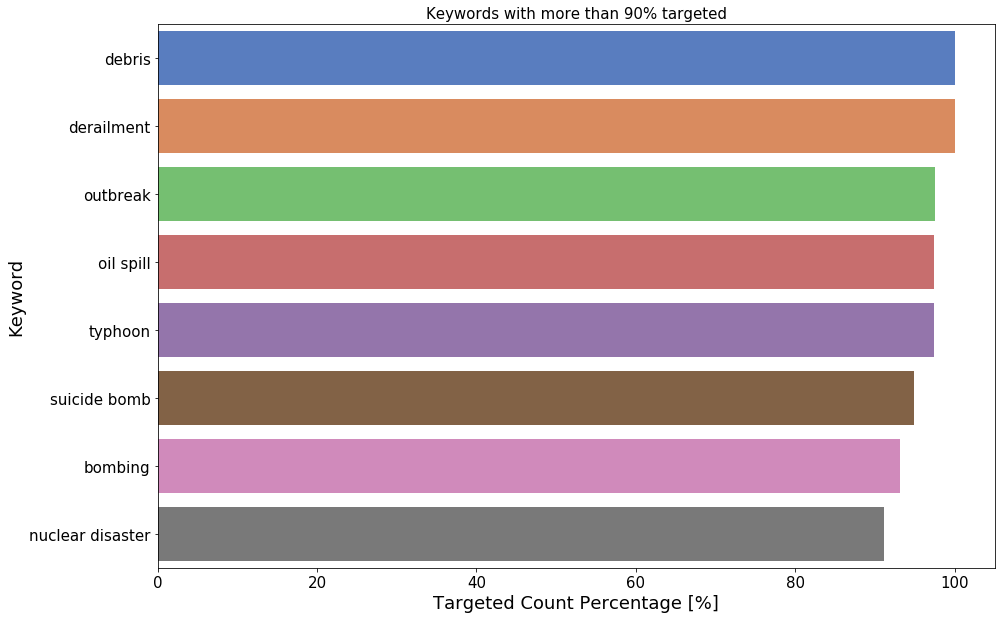

In [565]:
targeted_keywords = targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=targeted_keywords['percentage_count'], y=targeted_keywords['keyword_grouped'],
               orient='h')

g.set_title('Keywords with more than 90% targeted', fontsize=15)
g.set_xlabel('Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

# Keywords de tweets menos acertados, tomando como >= 90% not targeted y frecuencia mayor a 10 (Falsos)


In [566]:
not_targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['total_count'] >= 10) & (keywords['target'] == 0)]
not_targeted_keywords

keyword_grouped  target  count  total_count  percentage_count
4        aftershock       0     34           34        100.000000
29           blight       0     30           32         93.750000
35         body bag       0    100          107         93.457944
115       epicentre       0     11           12         91.666667
149            harm       0     37           41         90.243902
179          mayhem       0     27           30         90.000000
201       panicking       0     65           70         92.857143
221            ruin       0     36           37         97.297297
235           smoke       0     31           34         91.176471
241       stretcher       0     30           33         90.909091

Text(0, 0.5, 'Keyword')

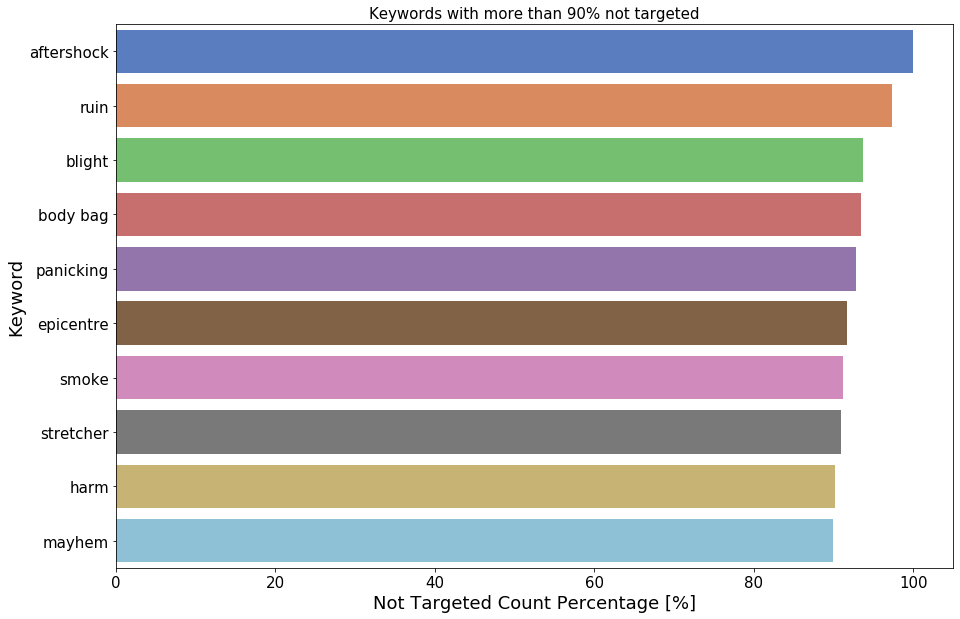

In [567]:
not_targeted_keywords = not_targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=not_targeted_keywords['percentage_count'], y=not_targeted_keywords['keyword_grouped'],
               orient='h')

g.set_title('Keywords with more than 90% not targeted', fontsize=15)
g.set_xlabel('Not Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

# Cómo varían los resultados anteriores relacionado al texto para el top 15 de desastres con más tweets?

Se agrupan algunas de las keyword y solo nos quedamos con el top15 (por cantidad de tweets)

In [568]:
key_list_top = tweets_text_key.keyword_grouped.value_counts().nlargest(15).index
tweets_text_key['keyword_top'] = tweets_text_key.keyword_grouped.transform(lambda x: x in key_list_top)
tweets_text_key_top = tweets_text_key.loc[tweets_text_key.keyword_top].copy()
tweets_text_key_top


text  keyword  target  \
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...   ablaze       1   
32    We always try to bring the heavy. #metal #RT h...   ablaze       0   
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...   ablaze       1   
34                   Crying out for more! Set me ablaze   ablaze       0   
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...   ablaze       0   
...                                                 ...      ...     ...   
7578   @jt_ruff23 @cameronhacker and I wrecked you both  wrecked       0   
7579  Three days off from work and they've pretty mu...  wrecked       0   
7580  #FX #forex #trading Cramer: Iger's 3 words tha...  wrecked       0   
7581  @engineshed Great atmosphere at the British Li...  wrecked       0   
7582  Cramer: Iger's 3 words that wrecked Disney's s...  wrecked       0   

     keyword_grouped  keyword_top  
31            ablaze         True  
32            ablaze         True  
33            ablaze         True  
34            ablaze         True  
35            ablaze         True  
...              ...          ...  
7578           wreck         True  
7579           wreck         True  
7580           wreck         True  
7581           wreck         True  
7582           wreck         True  

[1605 rows x 5 columns]

# Existen preguntas en los tweets del top 15 por tipo de desastre? como se relacionan estas con su veracidad

In [569]:
tweets_text_key_top['contain_question'] = tweets_text_key_top.text.transform(lambda x: "?" in x)

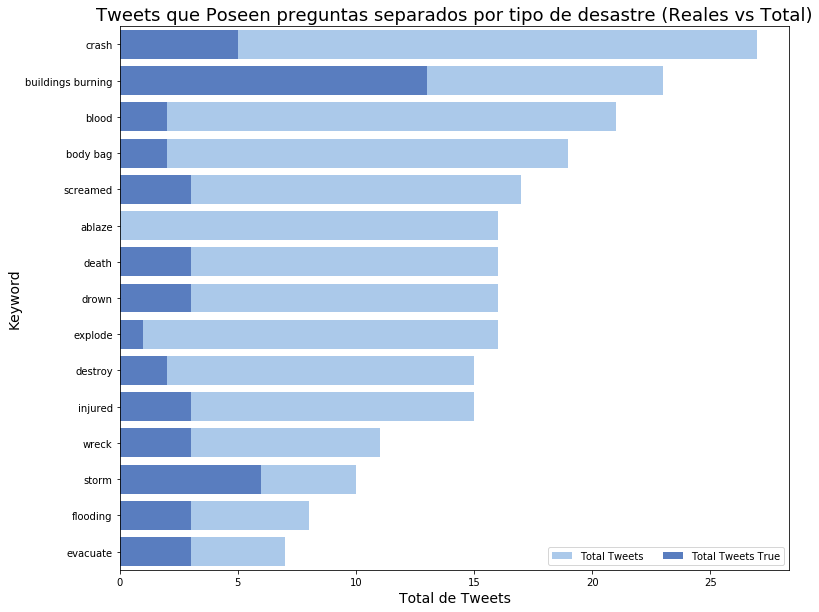

In [570]:
rcParams['figure.figsize'] = 12,10

sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_question == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas separados por tipo de desastre (Reales vs Total)",fontsize= 18)
ax.set_xlabel("Total de Tweets", fontsize= 14)
ax.set_ylabel("Keyword",fontsize= 14)

ax.legend(ncol=2, loc="lower right", frameon=True)


# Cómo se relaciona los tweets del top 15 por tipo de desastre que poseen  enlaces con su veracidad?

In [571]:
tweets_text_key_top['contain_link'] = tweets_text_key_top.text.transform(lambda x: "http" in x)

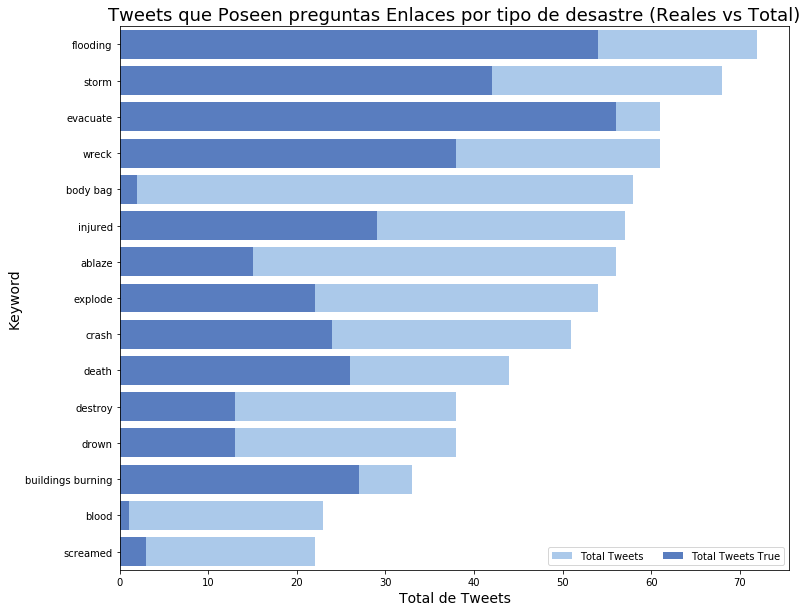

In [572]:
sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_link == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas Enlaces por tipo de desastre (Reales vs Total)",fontsize= 18)
ax.set_xlabel("Total de Tweets",fontsize= 14)
ax.set_ylabel("Keyword",fontsize= 14)
ax.legend(ncol=2, loc="lower right", frameon=True)


# ¿Cuáles son los paises con mas tweets?

In [573]:
#La transformación de las localidades es muy costosa (3 horas), por lo que se ha generado un .csv con esta columna
#agregada, la misma fue generada a través de la librería geopy.geocoders, el cual para una localidad dada devuelve un 
# objeto de tipo Location el cual posee una dirección, latitud y longitud. Esta herramienta permite agrupar por 
#localidades iguales pero escritas de forma distinta (ejemplo: NYC con new york city)

#tomar en cuenta que una parte de los registros no están ya que o no posee localidad o geocoders no pudo hallar su Location

tweets_location = pd.read_csv('./data/tweets_with_clean_location.csv', encoding='utf-8')
tweets_location.loc[:,'keyword'] = tweets_location.loc[:,'keyword'].str.replace("%20", " ")
tweets_location.dropna(subset=['location'],inplace=True)
tweets_location.sample(10)


Unnamed: 0     id           keyword              location  \
3844        3844   5469            flames           Freeport Ny   
4357        4357   6191          hijacker        Louisville, KY   
7136        7136  10222           volcano           Hawaii, USA   
1277        1277   1840            burned       Gainesville, FL   
3934        3934   5593             flood                   USA   
6199        6199   8848             smoke  MedellÌ_n, Antioquia   
2975        2975   4272          drowning            Hughes, AR   
5205        5205   7433       obliterated              Mid West   
5105        5105   7283  nuclear disaster        Washington, DC   
4476        4476   6366          hostages                 china   

                                                   text  target  \
3844  Just added some more fire to the flames for Sa...       0   
4357  Remove the http://t.co/VbqmZ5aPwj and Linkury ...       1   
7136  USGS EQ: M 1.9 - 5km S of Volcano Hawaii: Time...       1   
1277  burned 129 calories doing 24 minutes of Walkin...       1   
3934  Flood Advisory in effect for Shelby County in ...       1   
6199       Smoke the Weed - Snoop Lion Ft. Collie Buddz       0   
2975  http://t.co/9y0pAJ8sxd Family mourns drowning ...       1   
5205  Obliterated my phone screen today with a drum ...       0   
5105  Bombing #Iran would result in a never-ending g...       1   
4476  #hot  C-130 specially modified to land in a st...       0   

                             address_latitude_longitude         city  \
3844  ('Freeport, Nassau County, New York, 11520, Un...     Freeport   
4357  ('Louisville, Jefferson County, Kentucky, Unit...   Louisville   
7136  ('Hawaii, United States of America', 21.216043...       Hawaii   
1277  ('Gainesville, Alachua County, Florida, United...  Gainesville   
3934        ('United States', 39.7837304, -100.4458825)          NaN   
6199  ('Medellín, Zona Urbana Medellín, Medellín, Va...     Medellín   
2975  ('Hughes, Municipio de Hughes, Departamento Ge...       Hughes   
5205  ('Mid West, Diamond Park, Tunasan, Muntinlupa,...     Mid West   
5105  ('Washington, District of Columbia, 20500, Uni...   Washington   
4476                      ('中国', 35.000074, 104.999927)          NaN   

                        country   latitude   longitude  
3844   United States of America  40.657602  -73.583183  
4357   United States of America  38.254238  -85.759407  
7136   United States of America  21.216044 -157.975203  
1277   United States of America  29.651968  -82.324985  
3934                        NaN  39.783730 -100.445882  
6199                   Colombia   6.244338  -75.573553  
2975                  Argentina -33.801282  -61.336347  
5205                Philippines  14.348688  121.009474  
5105   United States of America  38.894985  -77.036571  
4476                        NaN  35.000074  104.999927

Text(0, 0.5, 'Pais')

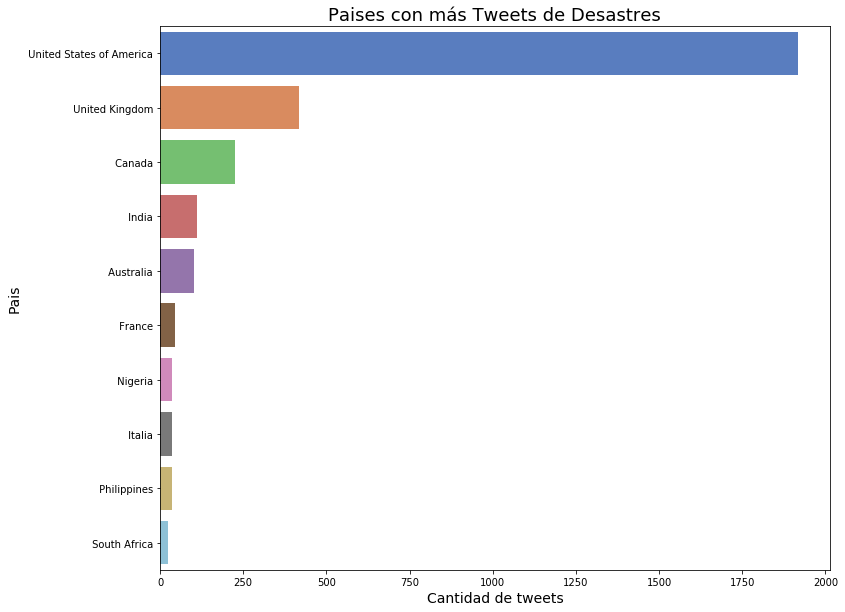

In [574]:
g=sns.barplot(x="country", y="index", data=tweets_location.country.value_counts().nlargest(10).to_frame().reset_index())

g.set_title('Paises con más Tweets de Desastres', fontsize=18)
g.set_xlabel('Cantidad de tweets', fontsize=14)
g.set_ylabel('Pais', fontsize=14)


In [575]:
fig = go.Figure()

# Recorremos los datos del archivo csv y extraemos sus coordenadas,
# etiquetas a mostrar y especificamos características del marcador
for i in tweets_location:
    fig.add_trace(go.Scattergeo(
            lon = tweets_location['longitude'],
            lat = tweets_location['latitude'],
            marker = dict(
                size = 1,
                color = 'red',
                line_color='white',
                line_width=0.5,
                sizemode = 'area'
        )))
 
# Establecemos las características del mapa base, el título y opciones
# de leyenda, así como la propia proyección del mapa.
fig.update_layout(
    title_text = 'Distribución de los Tweets en el Mundo',
    showlegend = False,
    geo = dict(
        scope='world',
        resolution=110,
        projection_type='mollweide',
        showcoastlines=True,
        showocean=True,
        oceancolor='#132630',
        lakecolor='#132630',
        coastlinecolor='#224354',
        landcolor='#224354',
    )
)
 
# Mostramos la figura creada con las características dadas
fig.show()

# Top 5 países con más de 20 tweets y la cantidad de tweets reales relativo de desastre

In [576]:
count_by_country = tweets_location.groupby(['country']).size().to_frame()
count_by_country.reset_index(inplace=True)
count_by_country.columns = ['country', 'ctry_count']
targeted_tweets_location = tweets_location.loc[tweets_location['target'] == 1].groupby(['country']).size().to_frame()
targeted_tweets_location.reset_index(inplace=True)
targeted_tweets_location.columns = ['country', 'targeted_ctry_count']
count_by_country = count_by_country.merge(targeted_tweets_location, left_on='country', right_on='country')
count_by_country.loc[:,'relative_targeted_ctry_count'] = (count_by_country.loc[:,'targeted_ctry_count'] / count_by_country.loc[:, 'ctry_count'] ) * 100
top_5_ctry_targeted = count_by_country.loc[count_by_country['ctry_count'] > 20].nlargest(5, ['relative_targeted_ctry_count'])



Text(0, 0.5, 'Country')

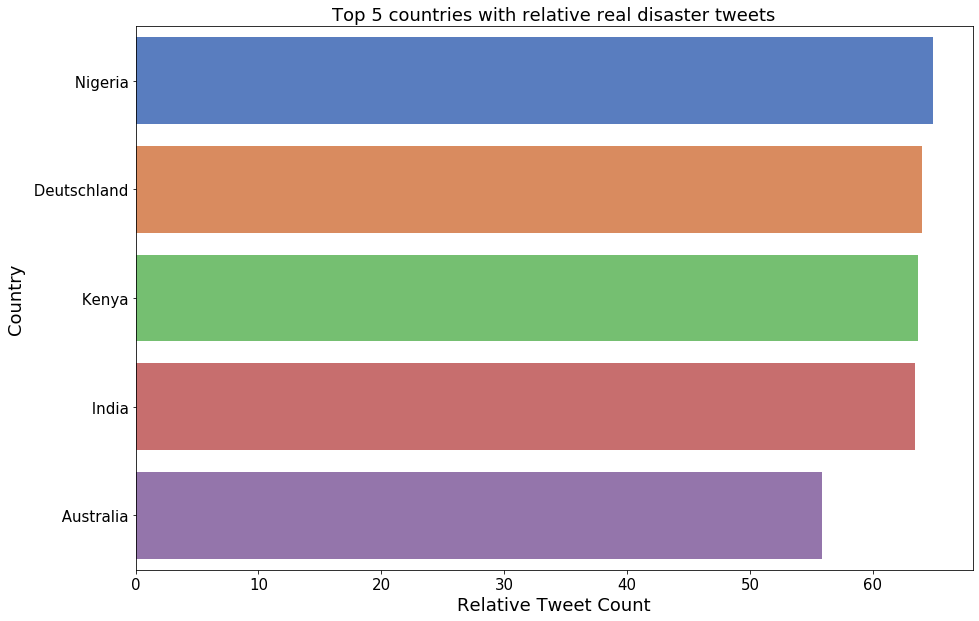

In [577]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=top_5_ctry_targeted['relative_targeted_ctry_count'], y=top_5_ctry_targeted['country'],
               orient='h')

g.set_title('Top 5 countries with relative real disaster tweets', fontsize=18)
g.set_xlabel('Relative Tweet Count', fontsize=18)
g.set_ylabel('Country', fontsize=18)

# Top 5 países con más de 20 tweets y la cantidad de tweets falsos relativo de desastre

In [578]:
not_targeted_tweets_location = tweets_location.loc[tweets_location['target'] == 0].groupby(['country']).size().to_frame()
not_targeted_tweets_location.reset_index(inplace=True)
not_targeted_tweets_location.columns = ['country','not_targeted_ctry_count']
count_by_country = count_by_country.merge(not_targeted_tweets_location, left_on='country', right_on='country')
count_by_country.loc[:,'relative_not_targeted_ctry_count'] = count_by_country.loc[:,'not_targeted_ctry_count'] / count_by_country.loc[:, 'ctry_count']
top_5_ctry_not_targeted = count_by_country.loc[count_by_country['ctry_count'] > 20].nlargest(5, ['relative_not_targeted_ctry_count'])


Text(0, 0.5, 'Country')

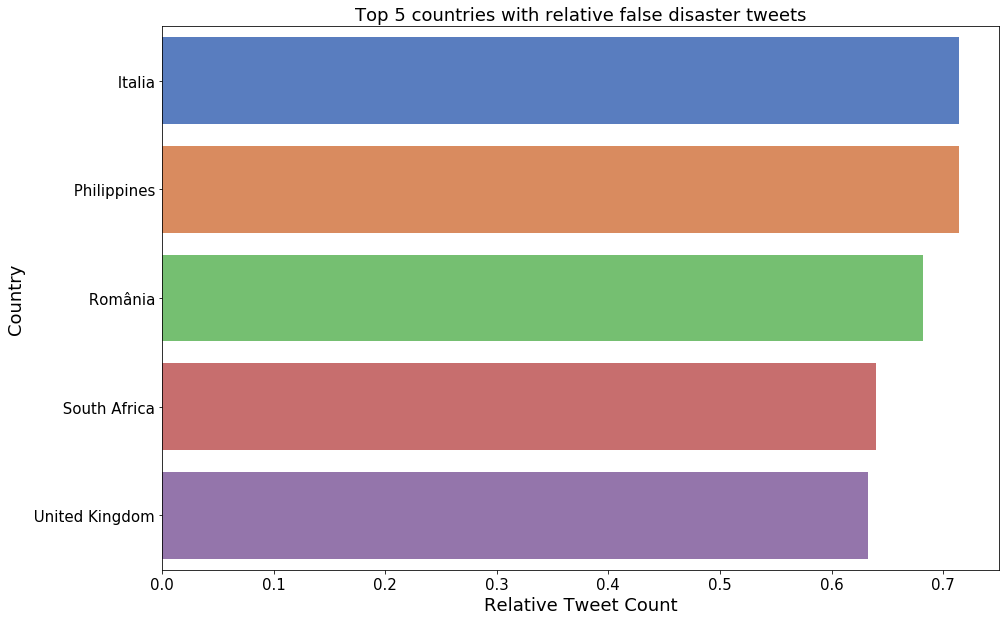

In [579]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=top_5_ctry_not_targeted['relative_not_targeted_ctry_count'], y=top_5_ctry_not_targeted['country'],
               orient='h')

g.set_title('Top 5 countries with relative false disaster tweets', fontsize=18)
g.set_xlabel('Relative Tweet Count', fontsize=18)
g.set_ylabel('Country', fontsize=18)